In [1]:
import matplotlib.pyplot as plt
from time import time
from simfunctions import *

import matplotlib as mpl

# Take colors at regular intervals spanning the colormap.
colors = mpl.colormaps['Dark2'].colors

# SI Model

$$ S + I \to I + I, c_1x_Sx_I $$
$$ S \to I, c_2x_S $$
with parameters $c_1 = 0.008, c_2=0.1$


In [2]:
def rate1(X):
    rate = 0.008*X[0]*X[1]
    if rate > 0:
        return rate
    else:
        return 0

def rate2(X):
    rate = 0.1*X[0]
    if rate > 0:
        return rate
    else:
        return 0
    
def jac(X):
    return np.array([[0.008*X[1], 0.008*X[0]], [0.1, 0]])

# Example usage:
drift = [rate1, rate2]
S_matrix = np.array([[-1, 1], [-1, 1]])  # Stoichiometry matrix
c = np.array([1,1])  # Reaction rates
X0 = np.array([90, 10])  # Initial state
T = 3  # Total time

## Tau-Leaping

0.0 % simulations completed
10.0 % simulations completed
20.0 % simulations completed
30.0 % simulations completed
40.0 % simulations completed
50.0 % simulations completed
60.0 % simulations completed
70.0 % simulations completed
80.0 % simulations completed
90.0 % simulations completed
Computed in:  1.068
Number of steps:  11


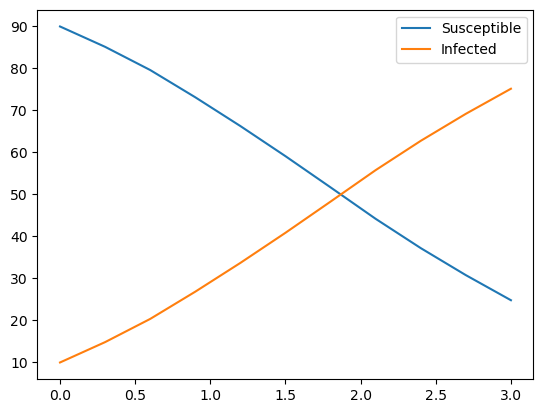

In [3]:
tau = 0.3  # Leap size

n_runs = 1000
runs = []

start = time()
for run in range(n_runs):
    if 100*run/n_runs % 10 == 0:
        print(100*run/n_runs, '% simulations completed')
    X = None
    while X is None:
        X, t_tau = tau_leaping(drift, S_matrix, c, X0, T, tau)
    runs.append(X)
end = time()

print('Computed in: ', np.round(end-start, 3))

print('Number of steps: ', len(X))

Xs = np.mean(np.array(runs)[:,:,0], axis=0)
Xi = np.mean(np.array(runs)[:,:,1], axis=0)

plt.plot(t_tau, Xs, label='Susceptible')
plt.plot(t_tau, Xi, label='Infected')
plt.legend()

## Mean-field

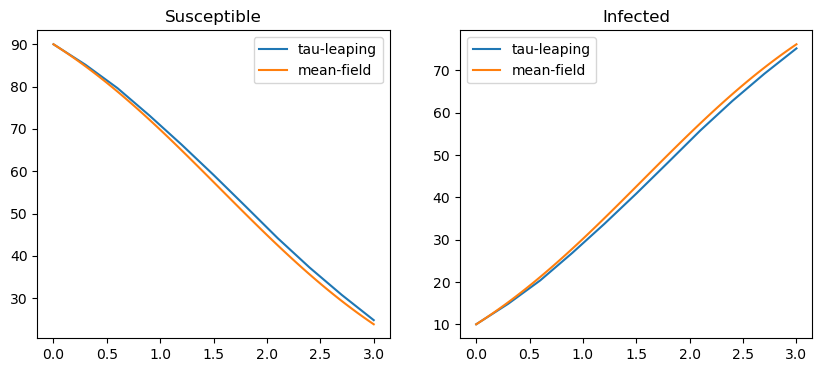

In [4]:
tmf = np.linspace(0,T, 100)
Xmf = mean_field(drift,S_matrix,c,X0,tmf)

fig, axs = plt.subplots(1,2, figsize=(10,4))

axs[0].plot(t_tau, Xs, label='tau-leaping')
axs[0].plot(tmf, Xmf[:,0], label='mean-field')
axs[0].set_title('Susceptible')
axs[0].legend()

axs[1].plot(t_tau, Xi, label='tau-leaping')
axs[1].plot(tmf, Xmf[:,1], label='mean-field')
axs[1].set_title('Infected')
axs[1].legend()

## SOGA - Gaussian Approximation

In [5]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

compiledFile=compile2SOGA('../programs/SOGA/SSA/Factorized_SI.soga')
cfg = produce_cfg(compiledFile)
start = time()
output_dist, fact_dynams = start_SOGA(cfg)
end = time()

print('Computed in {}s'.format(np.round(end-start,3)))

Computed in 0.397s


In [6]:
fact_dynams

{0: (array([ 0.,  0., 90., 10.]),
  array([[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]])),
 1: (array([90.  , 10.  , 85.14, 14.86]),
  array([[ 0.  ,  0.  ,  0.  ,  0.  ],
         [ 0.  ,  0.  ,  0.  ,  0.  ],
         [ 0.  ,  0.  ,  4.86, -4.86],
         [ 0.  ,  0.  , -4.86,  4.86]])),
 2: (array([85.14      , 14.86      , 79.56103104, 20.43896896]),
  array([[  4.86      ,  -4.86      ,   4.86      ,  -4.86      ],
         [ -4.86      ,   4.86      ,  -4.86      ,   4.86      ],
         [  4.86      ,  -4.86      ,  10.58188324, -10.58188324],
         [ -4.86      ,   4.86      , -10.58188324,  10.58188324]])),
 3: (array([79.56103104, 20.43896896, 73.29684756, 26.70315244]),
  array([[ 10.58188324, -10.58188324,  10.58188324, -10.58188324],
         [-10.58188324,  10.58188324, -10.58188324,  10.58188324],
         [ 10.58188324, -10.58188324,  17.06993188, -17.06993188],
         [-10.58188324,  10.58188324, -17.06993188

In [7]:
t = len(t_tau)

xs = np.zeros(t)
xi = np.zeros(t)
stds = np.zeros(t)
stdi = np.zeros(t)

for i in range(t):
    mu, cov = fact_dynams[i]
    xs[i] = mu[2]
    stds[i] = np.sqrt(cov[2,2])
    xi[i] = mu[3]
    stdi[i] = np.sqrt(cov[3,3])

Text(0, 0.5, 'Number of individuals')

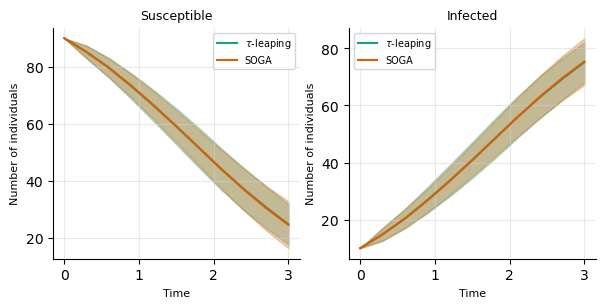

In [8]:
fig, axs = plt.subplots(1,2, figsize=(7,3))

stdS = np.std(np.array(runs)[:,:,0], axis=0)
stdI = np.std(np.array(runs)[:,:,1], axis=0)

axs[0].plot(t_tau, Xs, label=r'$\tau$-leaping', color=colors[0])
axs[0].fill_between(t_tau, Xs-stdS, Xs+stdS ,alpha=0.3, color=colors[0])
#axs[0].plot(tmf, Xmf[:,0], label='mean-field', color='green')
axs[0].plot(t_tau, xs, label='SOGA', color=colors[1])
axs[0].fill_between(t_tau, xs-stds, xs+stds ,alpha=0.3, color=colors[1])
axs[0].set_title('Susceptible', fontsize=9)
#axs[0].axhline(0)
axs[0].legend(fontsize = 7)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].grid(color='lightgray', alpha=0.5, zorder=1)
axs[0].set_xlabel('Time', fontsize=8)
axs[0].set_ylabel('Number of individuals', fontsize=8)

axs[1].plot(t_tau, Xi, label=r'$\tau$-leaping', color = colors[0])
axs[1].fill_between(t_tau, Xi-stdI, Xi+stdI, alpha=0.3, color=colors[0])
#axs[1].plot(tmf, Xmf[:,1], label='mean-field', color='green')
axs[1].plot(t_tau, xi, label='SOGA', color=colors[1])
axs[1].fill_between(t_tau, xi-stdi, xi+stdi ,alpha=0.3, color=colors[1])
axs[1].set_title('Infected', fontsize=9)
#axs[1].axhline(0)
axs[1].legend(fontsize = 7)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].grid(color='lightgray', alpha=0.5, zorder=1)
axs[1].set_xlabel('Time', fontsize=8)
axs[1].set_ylabel('Number of individuals', fontsize=8)